In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/carbon/Carbon Emission.csv')
# Selecting a subset of numerical features for clustering
numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(['CarbonEmission'], axis=1)


In [ ]:

# # Scaling the numerical features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(numerical_features)

# # Elbow method to determine the optimal number of clusters
# sse = {}
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(scaled_features)
#     sse[k] = kmeans.inertia_  # Sum of squared distances to closest cluster center

# # Plotting the elbow graph
# plt.figure(figsize=(10, 6))
# plt.plot(list(sse.keys()), list(sse.values()), marker='o')
# plt.title('Elbow Method for Determining Optimal Number of Clusters')
# plt.xlabel('Number of Clusters')
# plt.ylabel('SSE')
# plt.xticks(range(1, 11))
# plt.grid(True)
# plt.show()


In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values for 'Vehicle Type' by replacing them with 'unknown'
df['Vehicle Type'].fillna('unknown', inplace=True)

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the target variable
y = df['CarbonEmission']

# Define the features
X = df.drop(['CarbonEmission'], axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(random_state=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=0)  # Best parameters ('model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.8, random_state=0)
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', model)])
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

# Evaluate each model
results = {}
predictions = {}
for name, model in models.items():
    mse, r2, model_predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = (mse, r2)
    predictions[name] = model_predictions

results



{'Decision Tree': (589889.1745, 0.42779216801404785),
 'Random Forest': (298227.36456715, 0.7107117046816511),
 'Gradient Boosting': (270796.08684621035, 0.7373207570796849)}

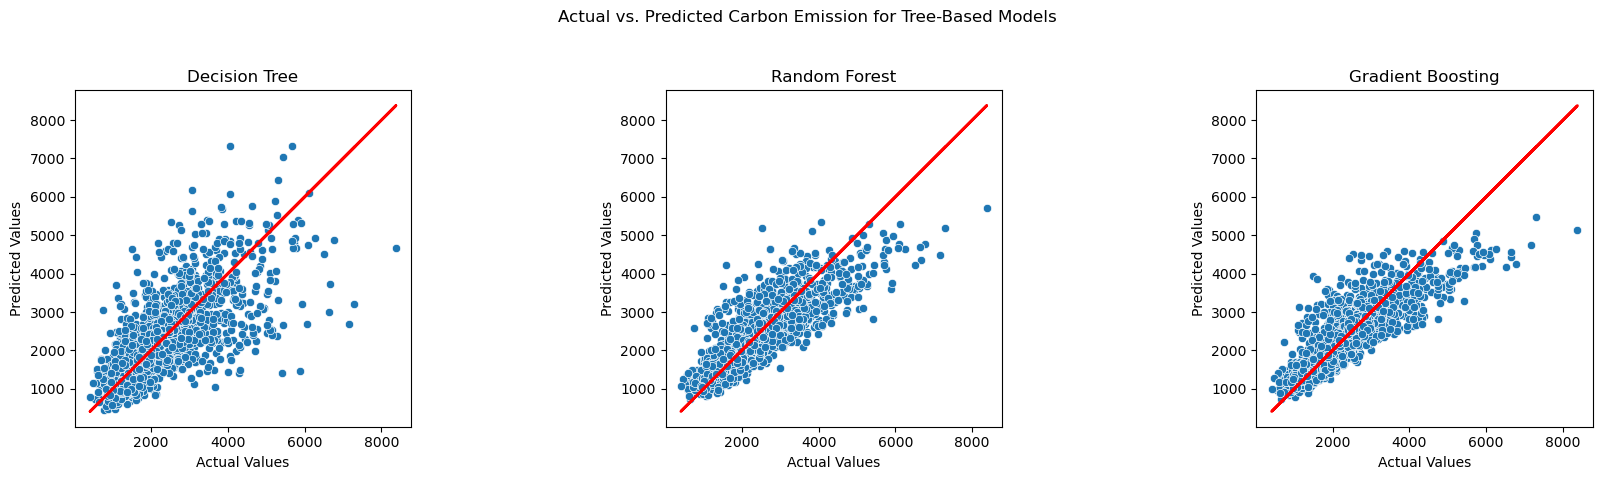

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model_predictions) in zip(axs, predictions.items()):
    sns.scatterplot(x=y_test, y=model_predictions, ax=ax)
    ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
    ax.set_title(name)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [25]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,unknown,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,unknown,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,unknown,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [4]:
import json

# Function to convert string representation of list to actual list
def string_to_list(string):
    try:
        return json.loads(string.replace("\'", "\""))
    except json.decoder.JSONDecodeError:
        return []

# Apply this function to 'Cooking_With' and 'Recycling' columns
df['Cooking_With'] = df['Cooking_With'].apply(string_to_list)
df['Recycling'] = df['Recycling'].apply(string_to_list)

# Function to one-hot encode lists in specified columns
def one_hot_encode_lists(df, column):
    # Get the union of all unique values in the lists of the column
    unique_values = set(item for sublist in df[column].tolist() for item in sublist)
    # Create a column for each unique value
    for value in unique_values:
        df[f"{column}_{value}"] = df[column].apply(lambda x: 1 if value in x else 0)
    return df

# Apply one-hot encoding to 'Cooking_With' and 'Recycling' columns
df = one_hot_encode_lists(df, 'Cooking_With')
df = one_hot_encode_lists(df, 'Recycling')

# Now, drop the original 'Cooking_With' and 'Recycling' columns
df.drop(['Cooking_With', 'Recycling'], axis=1, inplace=True)

# Re-select categorical columns (excluding the original 'Cooking_With' and 'Recycling' columns)
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in ['Cooking_With', 'Recycling']]

# Update the preprocessor with the new categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# Redefine the features (X) and target (y) with the updated dataframe
X = df.drop(['CarbonEmission'], axis=1)
y = df['CarbonEmission']

# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Re-evaluate each model with the updated dataset
updated_results = {}
updated_predictions = {}
for name, model in models.items():
    mse, r2, model_predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
    updated_results[name] = (mse, r2)
    updated_predictions[name] = model_predictions

updated_results


{'Decision Tree': (609067.15425, 0.4091890291720449),
 'Random Forest': (302835.268178215, 0.7062419184077757),
 'Gradient Boosting': (274600.06288439943, 0.7336308014476229)}

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Identify categorical and numerical columns
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'CarbonEmission']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


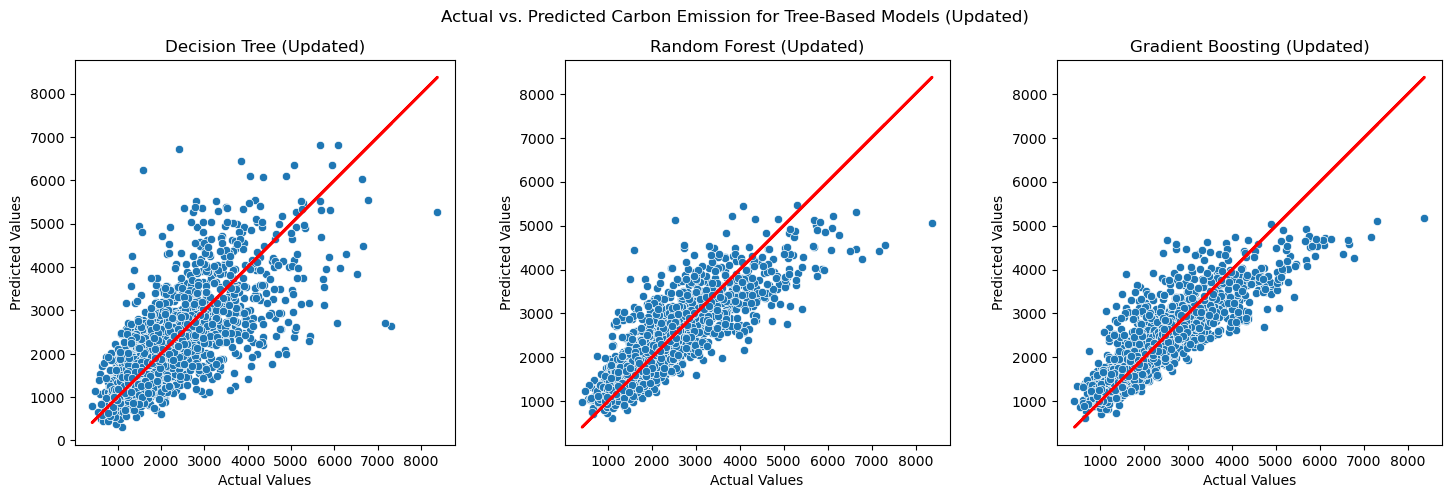

In [6]:
# Plotting the correlation between actual and predicted values for each updated model
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model_predictions) in zip(axs, updated_predictions.items()):
    sns.scatterplot(x=y_test, y=model_predictions, ax=ax)
    ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
    ax.set_title(name + " (Updated)")
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models (Updated)')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Identify categorical and numerical columns
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'CarbonEmission']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=0))
])

# Define the grid of hyperparameters to search
param_grid = {
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300],
    'model__subsample': [0.8, 0.9, 1]
}

# Configure Grid Search CV
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Split the dataset
X = df.drop('CarbonEmission', axis=1)
y = df['CarbonEmission']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit Grid Search CV
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE:", test_mse)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.9; total time=   1.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.9; total time=   1.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.9; total time=   1.5s
[CV] END model__learning

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=0))
])

# Define the grid of hyperparameters to search
param_grid = {
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300],
    'model__subsample': [0.8, 0.9, 1]
}

# Configure Grid Search CV
grid_search1 = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Split the dataset
X = df.drop('CarbonEmission', axis=1)
y = df['CarbonEmission']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit Grid Search CV
grid_search1.fit(X_train, y_train)

# Best parameters and score
best_params1 = grid_search1.best_params_
best_score1 = grid_search1.best_score_

print("Best Parameters:", best_params1)
print("Best Score:", best_score1)

# Evaluate the best model on the test set
best_model1 = grid_search1.best_estimator_
test_predictions1 = best_model1.predict(X_test)
test_mse1 = mean_squared_error(y_test, test_predictions1)
print("Test MSE:", test_mse1)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   3.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   3.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   3.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   3.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.9; total time=   3.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   3.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.9; total time=   3.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, mod

In [30]:
r2_score(y_test, test_predictions)

0.9854724697828253

In [31]:
mean_squared_error(y_test, test_predictions)

14976.433960350543

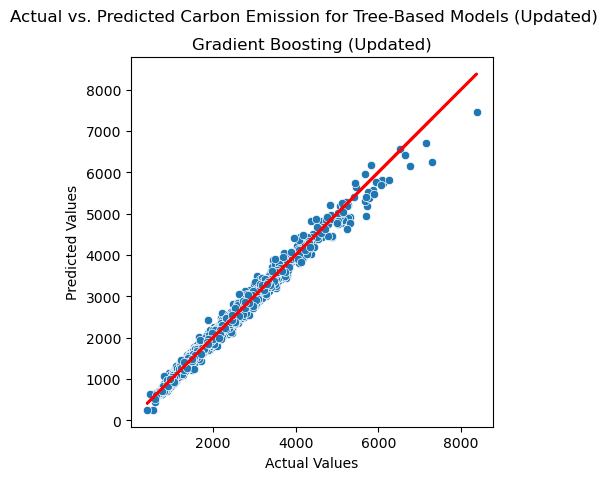

<Figure size 1000x800 with 0 Axes>

In [32]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

sns.scatterplot(x=y_test, y=test_predictions, ax=ax)
ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
ax.set_title(name + " (Updated)")
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models (Updated)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

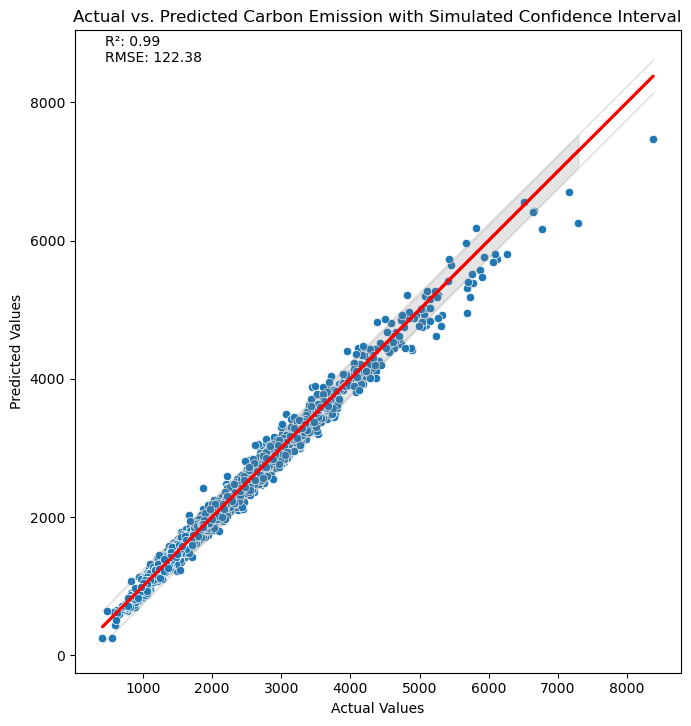

In [33]:
# Calculate metrics
r_squared = r2_score(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate the standard deviation of the errors
errors = test_predictions - y_test
error_std = np.std(errors)

# Plotting
plt.figure(figsize=(10, 8))

# Scatter plot of actual vs predicted values
sns.scatterplot(x=y_test, y=test_predictions)
plt.plot(y_test, y_test, color="red", linewidth=2)  # Perfect prediction line

# Shaded area for simulated confidence interval (assuming normal distribution of errors)
plt.fill_between(y_test, y_test - 1.96 * error_std, y_test + 1.96 * error_std, color='gray', alpha=0.2)

plt.title('Actual vs. Predicted Carbon Emission with Simulated Confidence Interval')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.text(0.05, 0.95, f'R²: {r_squared:.2f}\nRMSE: {rmse:.2f}', transform=plt.gca().transAxes)

plt.gca().set_aspect('equal', 'box')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


## Need for ``explanability``

In [26]:
import shap
import xgboost as xgb


In [12]:
df = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/carbon/Carbon Emission.csv')
# Selecting a subset of numerical features for clustering
# numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(['CarbonEmission'], axis=1)
# Assuming df is your DataFrame and 'CarbonEmission' is the target variable
# X = df.drop('CarbonEmission', axis=1)
# y = df['CarbonEmission']
# print(df.head())
# Encoding categorical variables (if any) should be done before this step
import json

# Function to convert string representation of list to actual list
def string_to_list(string):
    try:
        return json.loads(string.replace("\'", "\""))
    except json.decoder.JSONDecodeError:
        return []

# Apply this function to 'Cooking_With' and 'Recycling' columns
df['Cooking_With'] = df['Cooking_With'].apply(string_to_list)
df['Recycling'] = df['Recycling'].apply(string_to_list)

# Function to one-hot encode lists in specified columns
def one_hot_encode_lists(df, column):
    # Get the union of all unique values in the lists of the column
    unique_values = set(item for sublist in df[column].tolist() for item in sublist)
    # Create a column for each unique value
    for value in unique_values:
        df[f"{column}_{value}"] = df[column].apply(lambda x: 1 if value in x else 0)
    return df

# Apply one-hot encoding to 'Cooking_With' and 'Recycling' columns
df = one_hot_encode_lists(df, 'Cooking_With')
df = one_hot_encode_lists(df, 'Recycling')

# Now, drop the original 'Cooking_With' and 'Recycling' columns
# df.drop(['Cooking_With', 'Recycling'], axis=1, inplace=True)

# Re-select categorical columns (excluding the original 'Cooking_With' and 'Recycling' columns)
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in ['Cooking_With', 'Recycling']]

# Update the preprocessor with the new categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])


In [13]:
# For the categorical variables from 'Body Type' to 'Monthly Grocery Bill', excluding columns with lists,
# we'll convert the string values to numerical by assigning numbers starting from 0 based on their frequency.
df['Vehicle Type'].fillna('Unknown', inplace=True)
categorical_columns = ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 
                       'Vehicle Type', 'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency', 
                       'Frequency of Traveling by Air']

# Convert categorical variables to numerical
for col in categorical_columns:
    # Get unique categories and their counts
    categories = df[col].value_counts().index.tolist()
    
    # Map categories to numbers based on frequency (0 to n_categories-1)
    category_to_number = {category: number for number, category in enumerate(categories)}
    
    # Replace the string values with numbers
    df[col] = df[col].map(category_to_number)

# Display the transformed values for verification
df[categorical_columns].head()


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Frequency of Traveling by Air,Waste Bag Size,Energy efficiency,Frequency of Traveling by Air
0,2,0,0,0,1,1,0,1,1,1,2,1
1,1,0,3,2,3,0,0,1,2,2,2,2
2,2,1,2,3,2,2,3,0,3,0,0,3
3,2,1,2,1,2,0,0,2,2,3,0,2
4,1,0,3,0,1,2,5,1,0,1,1,0


In [14]:
# Define the features (X) and target (y)
X = df.drop(['CarbonEmission', 'Recycling', 'Cooking_With'], axis=1)  # Exclude target and complex list columns for simplicity
y = df['CarbonEmission']

In [147]:
X.to_csv('encoded.csv', index=False)

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X and y are defined and ready
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END 

In [38]:
r2_score(y_test, y_pred)

0.9856902743497896

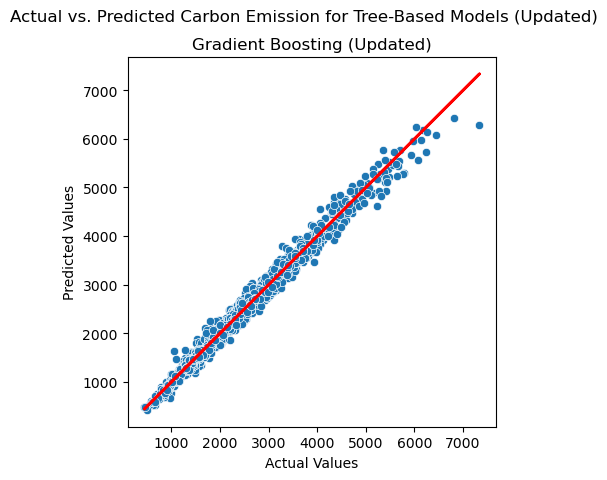

<Figure size 1000x800 with 0 Axes>

In [39]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

sns.scatterplot(x=y_test, y=y_pred, ax=ax)
ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
ax.set_title(name + " (Updated)")
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models (Updated)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [109]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=0)

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1]
}

# Configure Grid Search CV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed
# Run Grid Search
grid_search.fit(X_train, y_train)

# Extract the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Optionally, evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.3

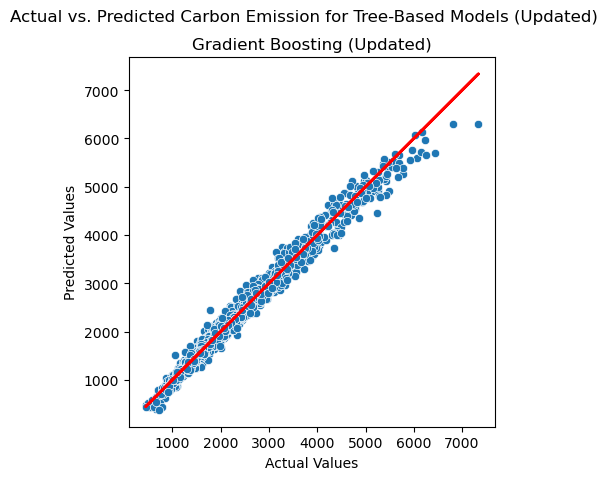

<Figure size 1000x800 with 0 Axes>

In [110]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

sns.scatterplot(x=y_test, y=test_predictions, ax=ax)
ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
ax.set_title(name + " (Updated)")
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models (Updated)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [111]:
r2_score(y_test, test_predictions)

0.9818782579997785

In [112]:
# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(xg_reg, X_test)
shap_values_xgb = explainer_xgb(X_test)

 95%|=================== | 1896/2000 [00:14<00:00]       

In [113]:
shap.initjs()

In [117]:
X.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Cooking_With_Microwave', 'Cooking_With_Grill',
       'Cooking_With_Oven', 'Cooking_With_Stove', 'Cooking_With_Airfryer',
       'Recycling_Glass', 'Recycling_Plastic', 'Recycling_Paper',
       'Recycling_Metal'],
      dtype='object')

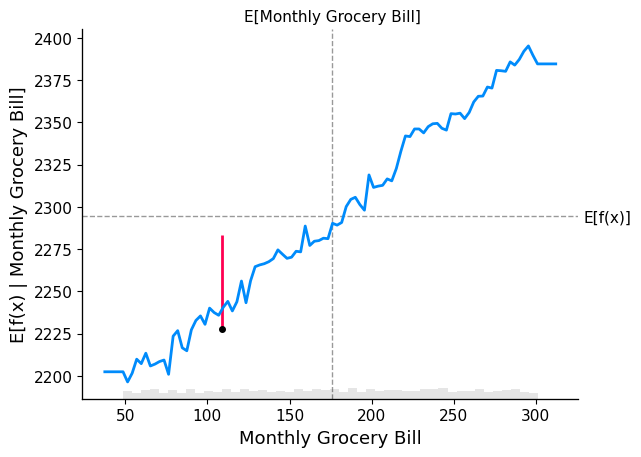

In [120]:
# make a standard partial dependence plot
sample_ind = 1000
shap.partial_dependence_plot(
    "Monthly Grocery Bill",
    xg_reg.predict,
    X_test,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)

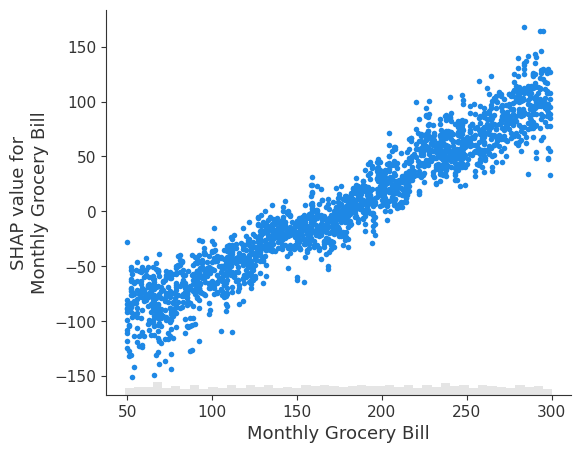

In [121]:
shap.plots.scatter(shap_values_xgb[:, "Monthly Grocery Bill"])

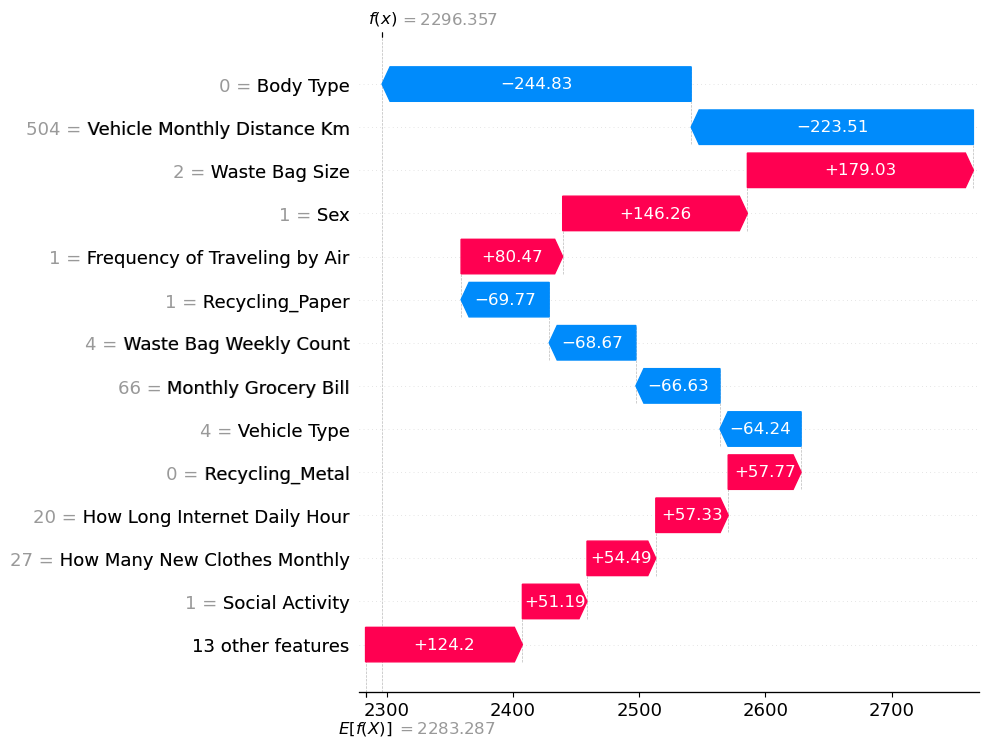

In [197]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_xgb[2], max_display=14)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


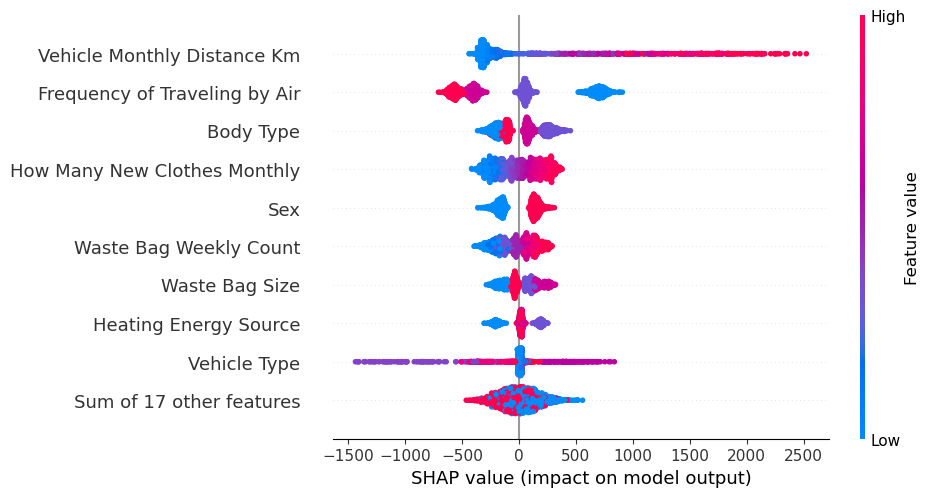

In [131]:
shap.plots.beeswarm(shap_values_xgb)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


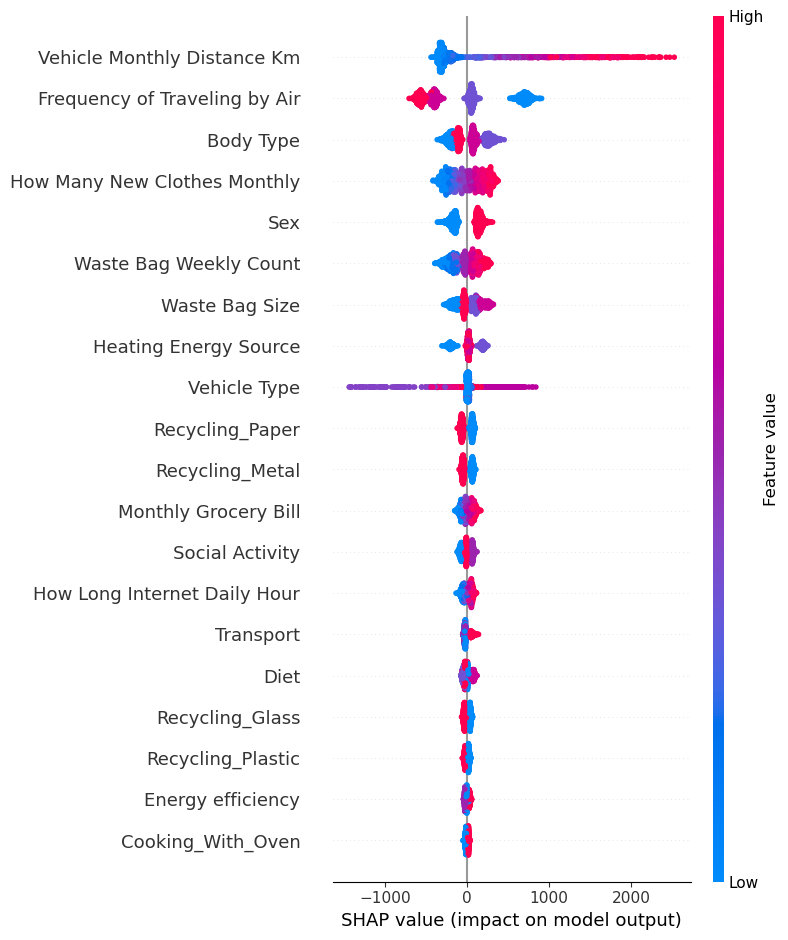

In [125]:
shap.summary_plot(shap_values_xgb, X_test)

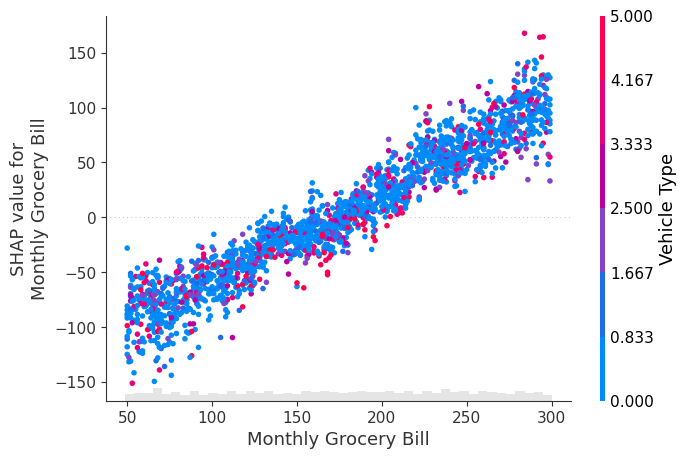

In [132]:
shap.plots.scatter(shap_values_xgb[:, "Monthly Grocery Bill"], color=shap_values_xgb)

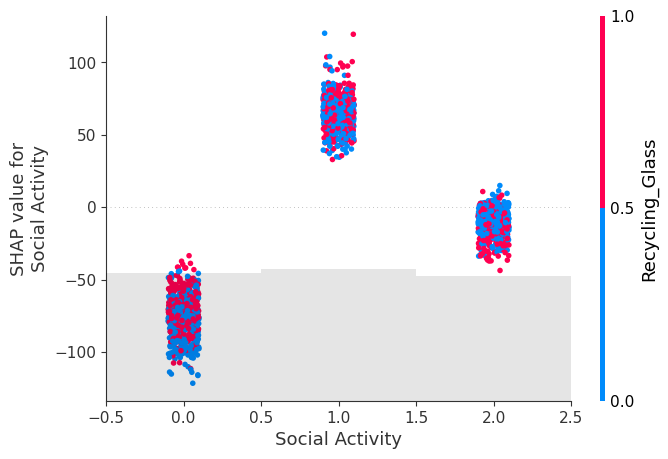

In [133]:
shap.plots.scatter(shap_values_xgb[:, "Social Activity"], color=shap_values_xgb)

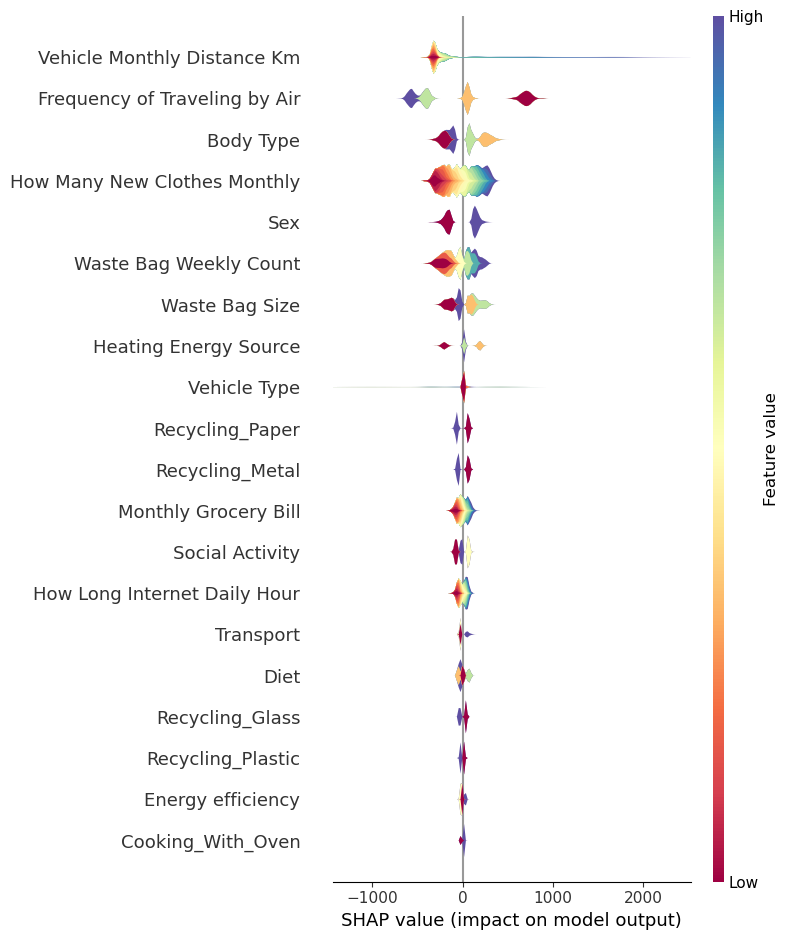

In [137]:
shap.summary_plot(
    shap_values_xgb[:, :],
    X_test.iloc[:, :],
    plot_type="layered_violin",
    color="Spectral",
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


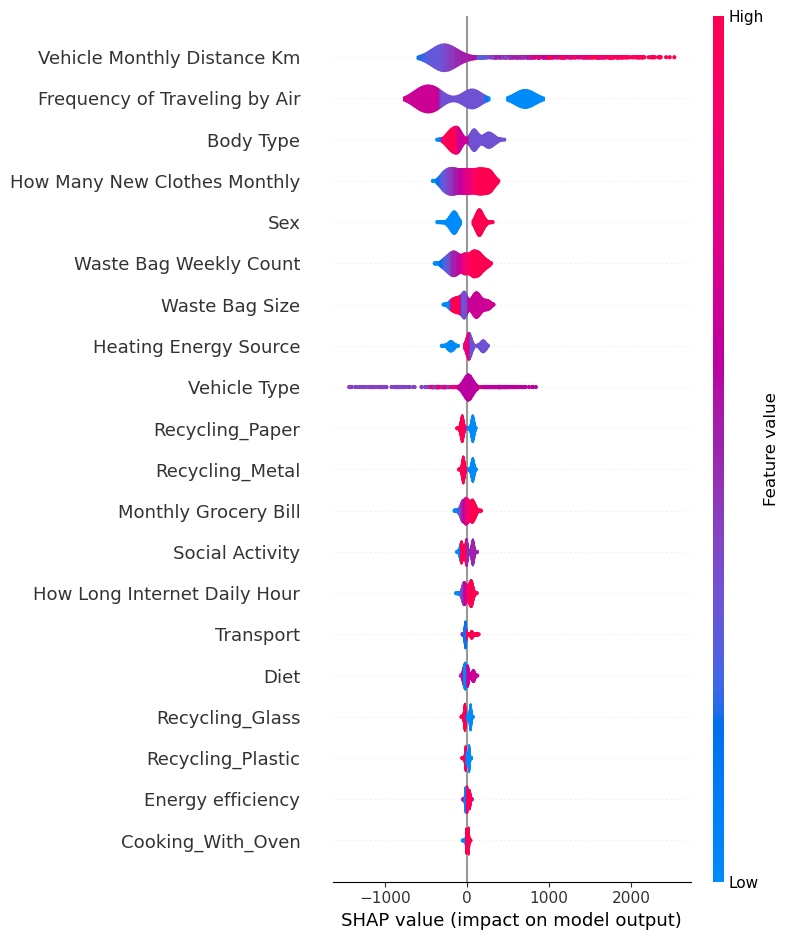

In [139]:
shap.summary_plot(shap_values_xgb[:, :], X_test.iloc[:, :], plot_type="violin")

In [141]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xg_reg)
explanation = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [145]:
shap.plots.force(explanation[0], plot_cmap='PkYg')

In [15]:
dfff = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/carbon/Carbon Emission.csv')
dfff.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [16]:
X.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,Energy efficiency,Cooking_With_Grill,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Stove,Cooking_With_Airfryer,Recycling_Glass,Recycling_Plastic,Recycling_Metal,Recycling_Paper
0,2,0,0,0,1,1,0,1,230,1,...,2,0,1,0,1,0,0,0,1,0
1,1,0,3,2,3,0,0,1,114,2,...,2,0,0,1,1,0,0,0,1,0
2,2,1,2,3,2,2,3,0,138,3,...,0,0,1,1,0,0,0,0,1,0
3,2,1,2,1,2,0,0,2,157,2,...,0,1,0,1,0,1,1,1,1,1
4,1,0,3,0,1,2,5,1,266,0,...,1,0,1,0,0,0,0,0,0,1


In [17]:
# Mapping for 'Body Type'
body_type_mapping = {'underweight': 0, 'normal': 1, 'overweight': 2, 'obese': 3}
X['Body Type'] = dfff['Body Type'].map(body_type_mapping)

# Mapping for 'How Often Shower'
shower_frequency_mapping = {'less frequently': 0, 'more frequently': 1, 'daily': 2, 'twice a day': 3}
X['How Often Shower'] = dfff['How Often Shower'].map(shower_frequency_mapping)
# Mapping for 'Waste'
waste_bag_mapping = {'small': 0, 'medium': 1, 'large': 2, 'extra large': 3}
X['Waste Bag Size'] = dfff['Waste Bag Size'].map(waste_bag_mapping)

# Mapping for 'Air travel'
air_travel_mapping = {'never': 0, 'rarely': 1, 'frequently': 2, 'very frequently': 3}
X['Frequency of Traveling by Air'] = dfff['Frequency of Traveling by Air'].map(air_travel_mapping)

# Mapping for 'Waste'
social_activity_mapping = {'never': 0, 'sometimes': 1, 'often': 2}
X['Social Activity'] = dfff['Social Activity'].map(social_activity_mapping)

# Mapping for 'Air travel'
energy_efficiency_mapping = {'No': 0, 'Sometimes': 1, 'Yes': 2}
X['Energy efficiency'] = dfff['Energy efficiency'].map(energy_efficiency_mapping)

In [18]:
import xgboost as xgb
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1.0
# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', subsample=1.0, colsample_bytree= 0.3, learning_rate=0.2, max_depth=3,n_estimators=1000)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 118.992076


In [19]:
r2_score(y_test, y_pred)


0.9863816478380747

In [198]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    # 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBRegressor()#(objective= 'reg:squarederror')

# Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
#                            scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search2 = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Perform grid search
# grid_search.fit(X_train, y_train)
grid_search2.fit(X_train, y_train)

# Extract the best parameters and score
best_params2 = grid_search2.best_params_
best_score2 = grid_search2.best_score_

print("Best Parameters:", best_params2)
print("Best Score:", best_score2)

# Optionally, evaluate the best model on the test set
best_model2 = grid_search2.best_estimator_
test_predictions2 = best_model2.predict(X_test)


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   2.1s
[CV] END learning_rate

KeyboardInterrupt: 

In [20]:
r2_score(y_test, test_predictions2)

NameError: name 'test_predictions2' is not defined

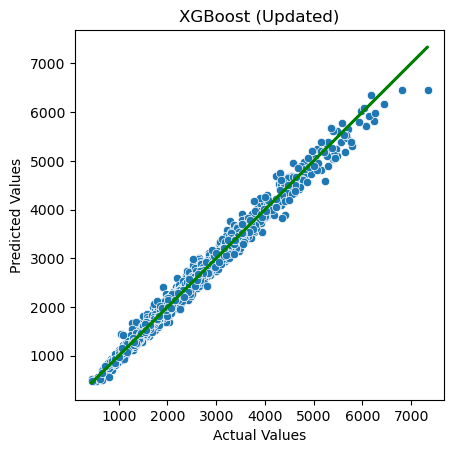

<Figure size 1000x800 with 0 Axes>

In [21]:

fig = plt.figure()
plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

sns.scatterplot(x=y_test, y=y_pred, ax=ax)
ax.plot(y_test, y_test, color="green", linewidth=2) # Perfect prediction line
ax.set_title('XGBoost' + " (Updated)")
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_aspect('equal', 'box')

# fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models (Updated)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [22]:
import shap

In [23]:
# explain the GAM model with SHAP
explainer = shap.Explainer(xg_reg, X_test)
shap_values = explainer(X_test)

 97%|=================== | 1945/2000 [00:18<00:00]       

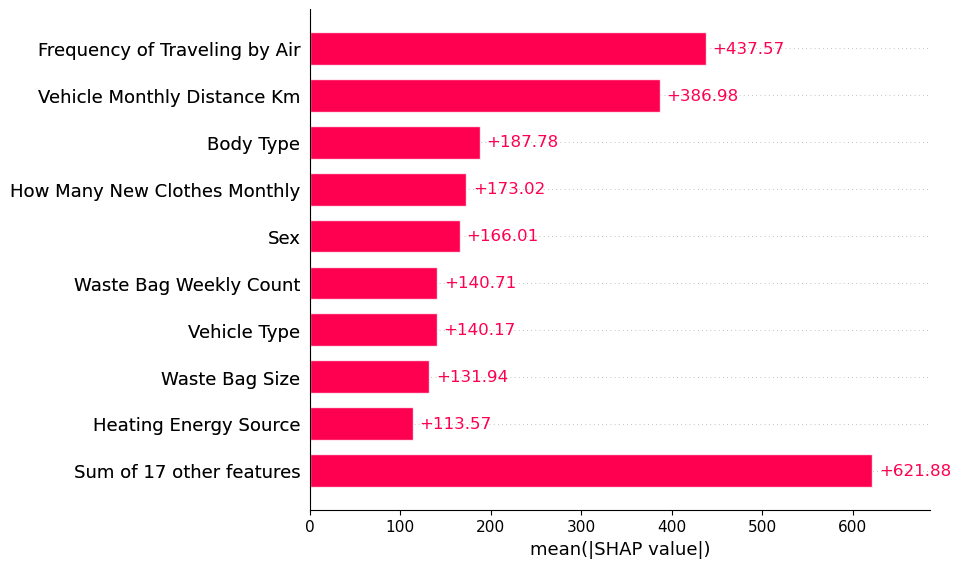

In [29]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


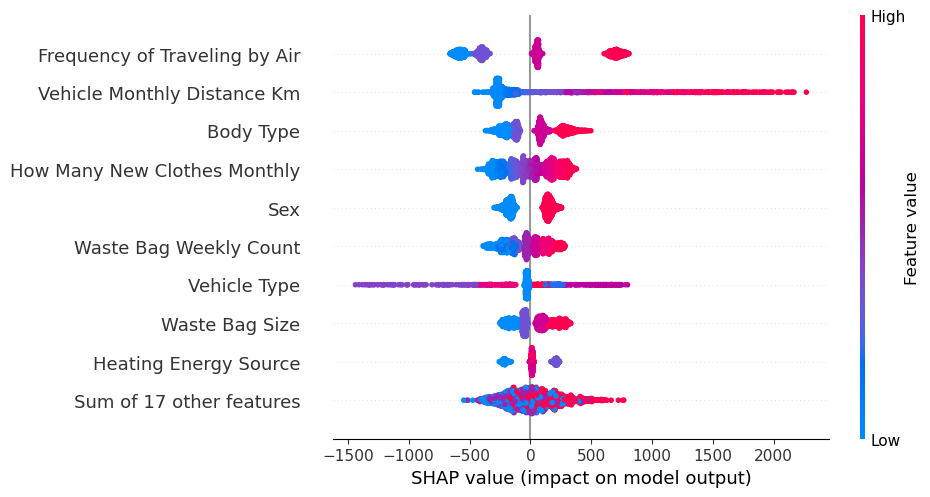

In [24]:
shap.plots.beeswarm(shap_values)

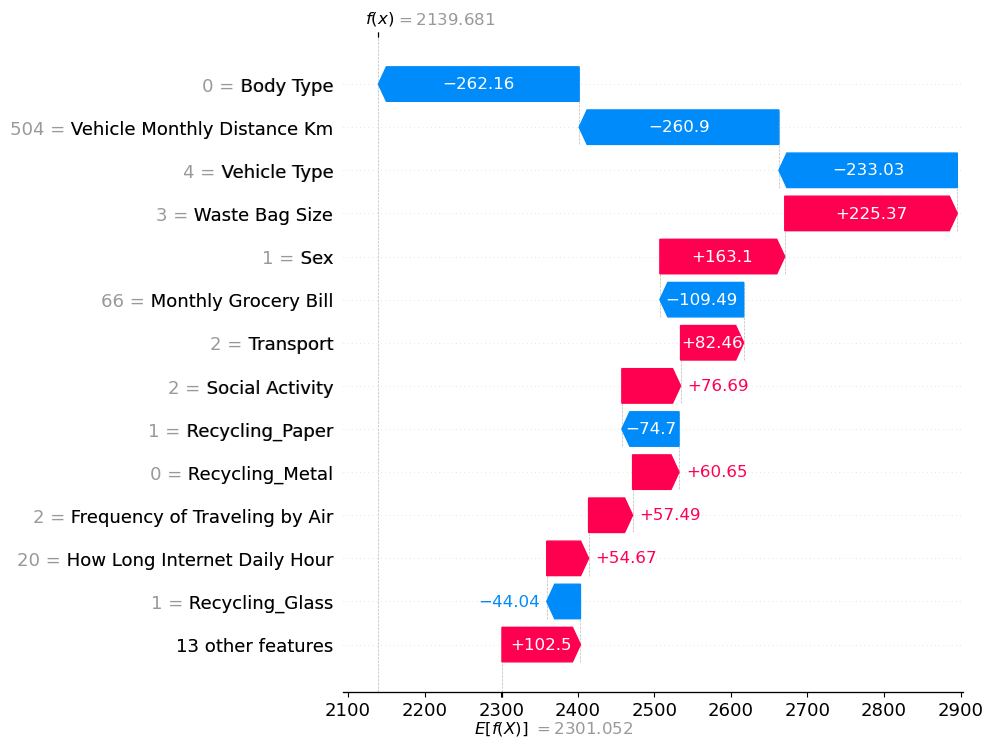

In [25]:
shap.plots.waterfall(shap_values[2], max_display=14)

In [26]:
# explain the model's predictions using SHAP values
explainer_local = shap.TreeExplainer(xg_reg)
explanation1 = explainer_local(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [27]:
shap.plots.force(explanation1[0], plot_cmap='PkYg')

In [28]:
shap.plots.force(explanation1[39], plot_cmap='PkYg')

In [30]:
X.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Cooking_With_Grill', 'Cooking_With_Oven',
       'Cooking_With_Microwave', 'Cooking_With_Stove', 'Cooking_With_Airfryer',
       'Recycling_Glass', 'Recycling_Plastic', 'Recycling_Metal',
       'Recycling_Paper'],
      dtype='object')

In [33]:
shap_values11 = shap.TreeExplainer(xg_reg).shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


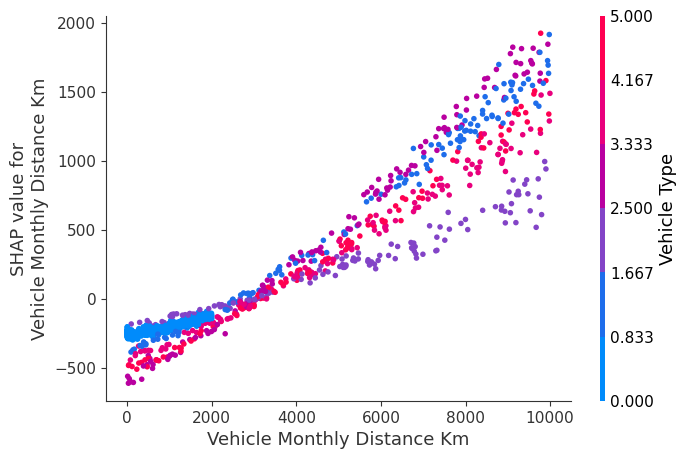

In [35]:
shap.dependence_plot("Vehicle Monthly Distance Km", shap_values11, X_test, show=False)
# plt.xlim(80, 225)
plt.show()

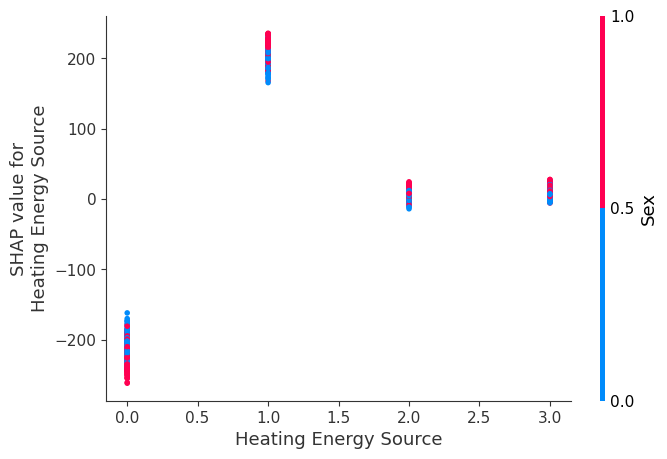

In [36]:
shap.dependence_plot("Heating Energy Source", shap_values11, X_test, show=False)
# plt.xlim(80, 225)
plt.show()